# Step 8: Training characters classifier

## Imports

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

from src.local_utils.constants import (
    RU_CHARACTERS_IMAGES_PATH,
    RU_CHARACTERS_BEST_MODEL_FILE,
    RU_CHARACTERS_HISTORY_FILE,
    VALIDATION_SPLIT
)
from src.local_utils.history import history2csv, csv2history
from src.networks.character_classifier import CharacterClassifier

## Preparing the data

In [2]:
X = []
Y = []

classnames = os.listdir(RU_CHARACTERS_IMAGES_PATH)
classname_paths = list(map(lambda clsname: os.path.join(RU_CHARACTERS_IMAGES_PATH, clsname), classnames))
for classname_index, classname_path in enumerate(classname_paths):
    image_pathes = list(map(lambda filename: os.path.join(classname_path, filename), os.listdir(classname_path)))
    for image_path in image_pathes:
        image = cv2.imread(image_path)
        X.append(image.astype('float32') / 255)
        Y.append(classname_index)

X = np.array(X)
Y = keras.utils.to_categorical(np.array(Y))

indexes = None
for _ in range(5):
    indexes = np.random.permutation(len(X))

train_data = X[indexes]
train_labels_cat = Y[indexes]

# now set-aside 10% of the train_data/labels as the
# cross-validation sets
val_count = int(VALIDATION_SPLIT * len(train_data))

# first pick validation set from train_data/labels
val_data = train_data[:val_count,:]
val_labels_cat = train_labels_cat[:val_count,:]

# leave rest in training set
train_data2 = train_data[val_count:,:]
train_labels_cat2 = train_labels_cat[val_count:,:]

## Loading model

In [3]:
model = CharacterClassifier(len(classnames))

In [4]:
if os.path.exists(RU_CHARACTERS_BEST_MODEL_FILE):
    model.load_weights(RU_CHARACTERS_BEST_MODEL_FILE)

## Training model

In [5]:
history = model.fit(
    train_data2,
    train_labels_cat2,
    epochs=100,
    batch_size=64,
    validation_data=(val_data, val_labels_cat),
    verbose=2,
    callbacks=[
        ModelCheckpoint(
            filepath=RU_CHARACTERS_BEST_MODEL_FILE,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
        )
    ]
)

Epoch 1/100
19/19 - 0s - loss: 1.1808 - accuracy: 0.8253 - val_loss: 0.2583 - val_accuracy: 0.9205
Epoch 2/100
19/19 - 0s - loss: 0.1628 - accuracy: 0.9594 - val_loss: 0.1105 - val_accuracy: 0.9603
Epoch 3/100
19/19 - 0s - loss: 0.0901 - accuracy: 0.9685 - val_loss: 0.0961 - val_accuracy: 0.9702
Epoch 4/100
19/19 - 0s - loss: 0.0777 - accuracy: 0.9768 - val_loss: 0.0615 - val_accuracy: 0.9735
Epoch 5/100
19/19 - 0s - loss: 0.0679 - accuracy: 0.9760 - val_loss: 0.1084 - val_accuracy: 0.9735
Epoch 6/100
19/19 - 0s - loss: 0.0539 - accuracy: 0.9801 - val_loss: 0.0624 - val_accuracy: 0.9735
Epoch 7/100
19/19 - 0s - loss: 0.0442 - accuracy: 0.9892 - val_loss: 0.0885 - val_accuracy: 0.9768
Epoch 8/100
19/19 - 0s - loss: 0.0534 - accuracy: 0.9851 - val_loss: 0.0741 - val_accuracy: 0.9801
Epoch 9/100
19/19 - 0s - loss: 0.0624 - accuracy: 0.9793 - val_loss: 0.0805 - val_accuracy: 0.9801
Epoch 10/100
19/19 - 0s - loss: 0.0452 - accuracy: 0.9892 - val_loss: 0.0735 - val_accuracy: 0.9801
Epoch 11/

## Save history

In [6]:
history2csv(history, RU_CHARACTERS_HISTORY_FILE)

Saving history to CSV file
	Done


## Charts

Reading the whole training history.

In [7]:
history = csv2history(RU_CHARACTERS_HISTORY_FILE)

Reading history from CSV file
	Done


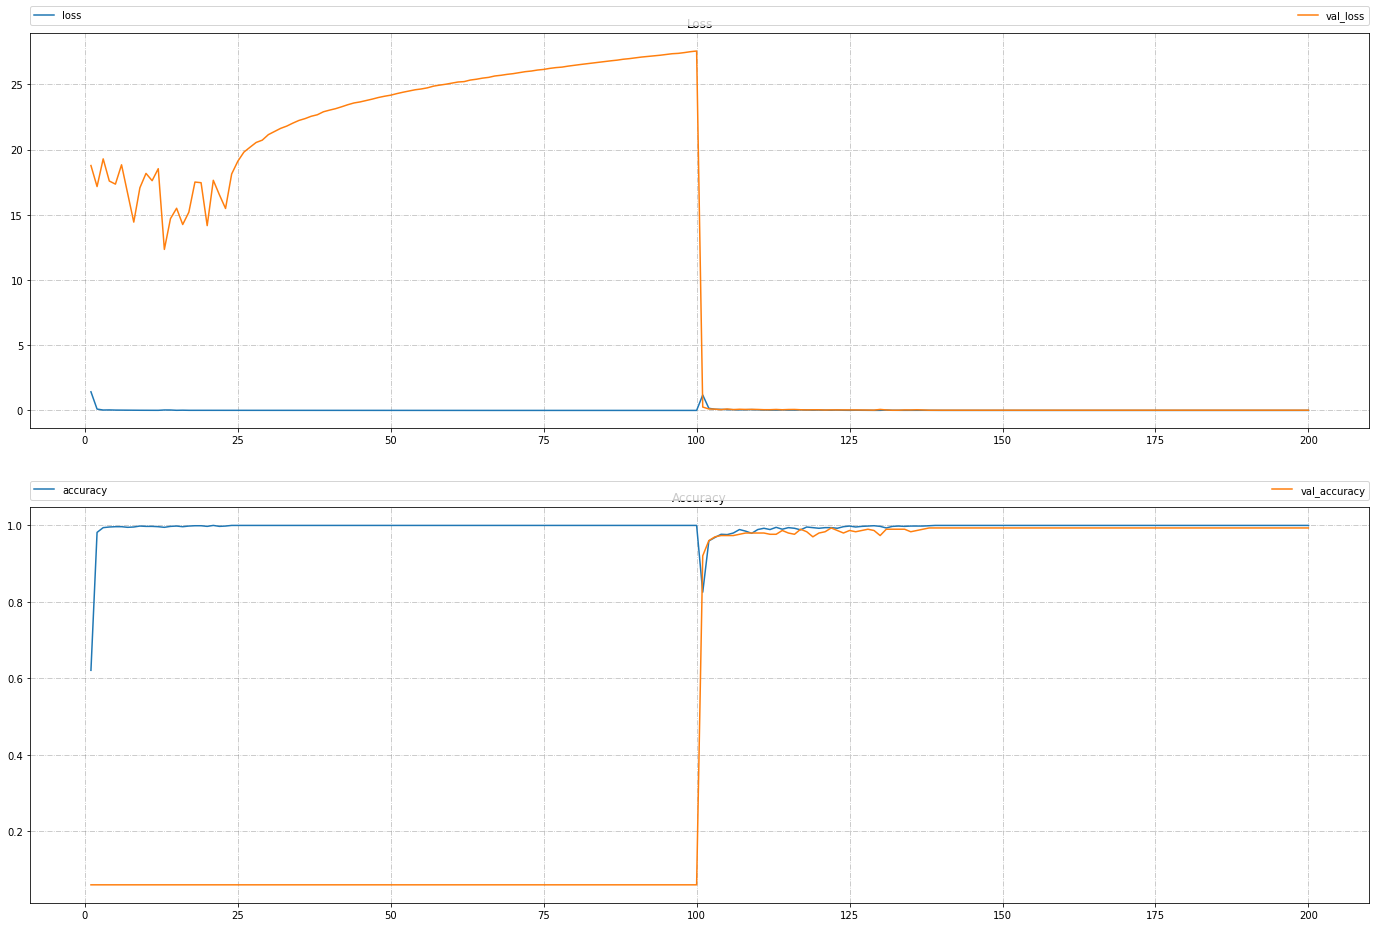

In [8]:
x = np.linspace(start=1, stop=history['epochs'], num=history['epochs'])

fig, (loss_chart, acc_chart) = plt.subplots(2)

fig.set_size_inches((24, 16))

loss_chart.set_title('Loss')
loss_chart.plot(x, history['loss'], label='loss')
loss_chart.plot(x, history['val_loss'], label='val_loss')
loss_chart.grid(b=True, color='gray', alpha=0.5, linestyle='dashdot')
loss_chart.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.0)

acc_chart.set_title('Accuracy')
acc_chart.plot(x, history['accuracy'], label='accuracy')
acc_chart.plot(x, history['val_accuracy'], label='val_accuracy')
acc_chart.grid(b=True, color='gray', alpha=0.5, linestyle='dashdot')
acc_chart.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.0)

plt.show()

In [9]:
test_loss, test_accuracy = model.evaluate(val_data, val_labels_cat, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

5/5 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9934
Test loss: 0.0185 accuracy: 0.9934


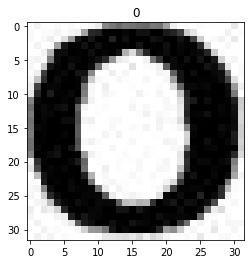

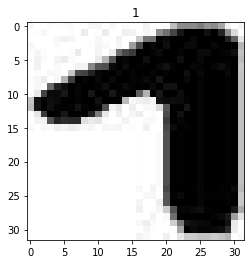

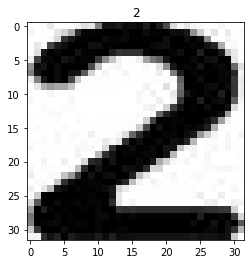

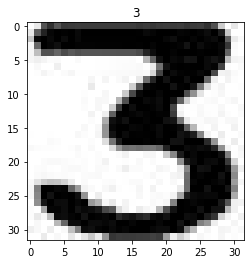

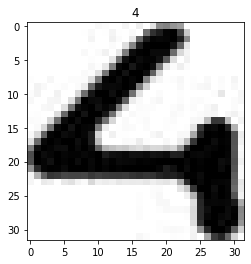

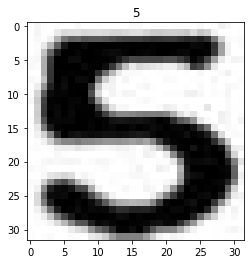

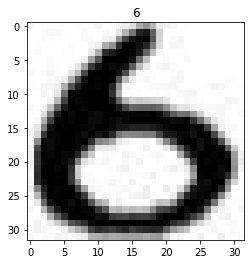

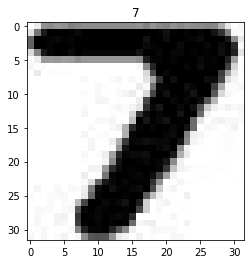

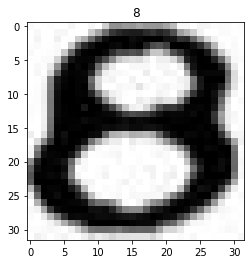

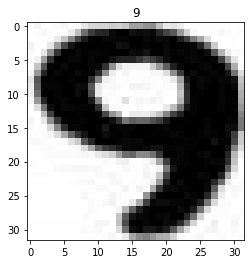

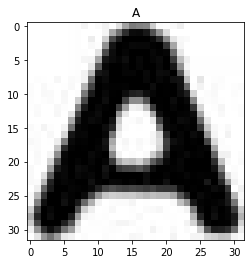

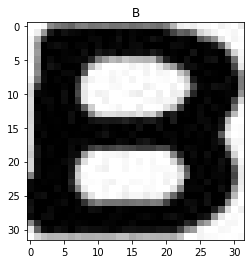

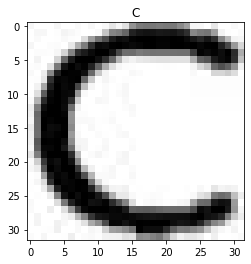

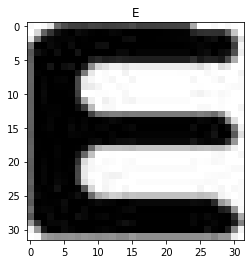

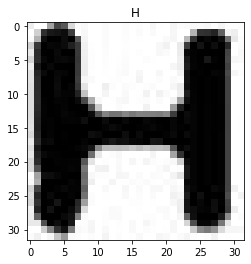

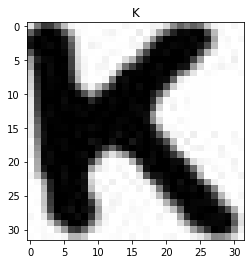

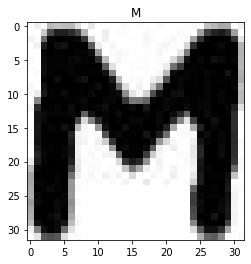

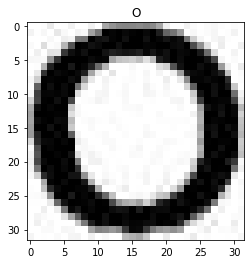

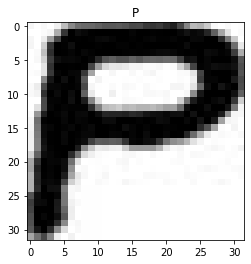

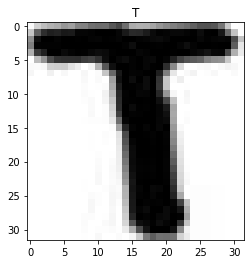

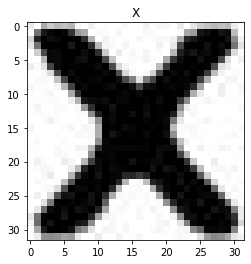

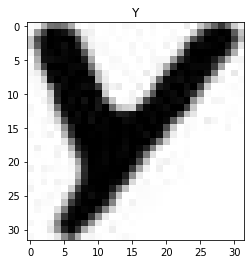

In [10]:
for classname_index, classname_path in enumerate(classname_paths):
    image_pathes = list(map(lambda filename: os.path.join(classname_path, filename), os.listdir(classname_path)[:1]))
    for image_path in image_pathes:
        image = cv2.imread(image_path)
        prepared_image = image.astype('float32') / 255
        score = model.predict(np.array([prepared_image]))

        plt.imshow(image)
        plt.title(classnames[np.argmax(score[0])])
        plt.show()